# Using tf-idf approach to generate features

### Loading all the necessary packages for the subsequant analysis:

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
import numpy as np
import glob
import string
import datetime

---
Functions from PyCharm to gather data in df format:

In [2]:
category = {
    1: 'politik', 2: 'wirtschaft', 3: 'finanzen', 4: 'feuilleton', 5: 'sport', 6: 'gesellschaft', 7: 'stil', 
    8: 'technik-motor', 9: 'wissen', 10: 'reise', 11: 'beruf-chance'
}

In [3]:
def train_tables(category):
    raw_train = []
    if category is 'aktuell':
        path = f"../new_data/aktuell/"
    else:
        path = f"../new_data/{category}/"
        
    all_files = glob.glob(path + '*.csv')

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        raw_train.append(df)
    faz_articles = pd.concat(raw_train, axis=0, ignore_index=True)
    faz_articles['label'] = category

    return faz_articles

def test_tables(category):
    raw_test = []
    if category is 'aktuell':
        path = f"../data/aktuell/"
    else:
        path = f"../data/{category}/"
        
    all_files = glob.glob(path + '*.csv')

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        raw_test.append(df)
    faz_article = pd.concat(raw_test, axis=0, ignore_index=True)
    faz_article['label'] = category

    return faz_article

---
---
# Generate Test and Train Data

This for-loop goes through the data frames built in the first step and then collects the words from each entry in a list.

## Train Data ['detailed']:

In [4]:
frames = []

for key, value in category.items():
    raw_faz = train_tables(value)
    frames.append(raw_faz)
    faz_train = pd.concat(frames, axis=0, ignore_index=True)
    
faz_train = faz_train.drop_duplicates()

Split the train set in the four classes we aim to predict in the end (Politics, Sports, Economy and the rest)

In [5]:
faz_pol = faz_train[faz_train.label == 'politik']
faz_pol['goal_val'] = 1

faz_sport = faz_train[faz_train.label == 'sport']
faz_sport['goal_val'] = 2

faz_eco = faz_train[faz_train.label == 'wirtschaft']
faz_eco['goal_val'] = 3

/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [6]:
faz_train_2 = faz_train.copy()

faz_train_2 = faz_train_2[faz_train_2.label != 'politik']
faz_train_2 = faz_train_2[faz_train_2.label != 'sport']
faz_train_2 = faz_train_2[faz_train_2.label != 'wirtschaft']
faz_rem = faz_train_2

faz_rem['goal_val'] = 0

In [7]:
train_conc = [faz_pol,faz_sport,faz_eco,faz_rem]
train = pd.concat(train_conc)

In [8]:
train_detailed = train.drop(columns=['link', 'published','title','label'])

## Train Data ['title']:

In [11]:
train_titles = train.drop(columns=['link', 'published','detailed','label'])

In [12]:
train_titles = train_titles.rename(index=str, columns={"title": "detailed"})

In [13]:
combined = [train_detailed,train_titles]
train_tot = pd.concat(combined)

---

In [14]:
X_train = train_detailed['detailed'].str.lower()
X_train_title = train_titles['detailed'].str.lower()
X_train_tot = train_tot['detailed'].str.lower()

In [15]:
y_train = train_detailed['goal_val']
y_train_title = train_titles['goal_val']
y_train_tot = train_tot['goal_val']

---

## Test Data['detailed']:

In [16]:
frames = []

for key, value in category.items():
    raw_faz = test_tables(value)
    frames.append(raw_faz)
    faz_test = pd.concat(frames, axis=0, ignore_index=True)
    
faz_test = faz_test.drop_duplicates()

In [17]:
faz_pol_t = faz_test[faz_test.label == 'politik']
faz_pol_t['goal_val'] = 1

faz_sport_t = faz_test[faz_test.label == 'sport']
faz_sport_t['goal_val'] = 2

faz_eco_t = faz_test[faz_test.label == 'wirtschaft']
faz_eco_t['goal_val'] = 3

/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [18]:
faz_test_2 = faz_test.copy()

faz_test_2 = faz_test_2[faz_test_2.label != 'politik']
faz_test_2 = faz_test_2[faz_test_2.label != 'sport']
faz_test_2 = faz_test_2[faz_test_2.label != 'wirtschaft']
faz_rem_t = faz_test_2

faz_rem_t['goal_val'] = 0

In [19]:
test_conc = [faz_pol_t,faz_sport_t,faz_eco_t,faz_rem_t]
test = pd.concat(test_conc) 

In [20]:
test_detailed = test.drop(columns=['link', 'published','title','label'])

## Test Data ['title']:

In [21]:
X_test = test_detailed['detailed'].str.lower()

In [22]:
y_test = test_detailed['goal_val']

In [23]:
print("# of entries - Training dataset: ", X_train.shape[0])
print("# of entries - Test dataset: ", X_test.shape[0])

# of entries - Training dataset:  1755
# of entries - Test dataset:  563


In [24]:
print('Trainset:')
print(train_tot.goal_val.value_counts())
print('\n')
print('Testset:')
print(test_detailed.goal_val.value_counts())

Trainset:
0    1538
1     788
2     676
3     508
Name: goal_val, dtype: int64


Testset:
0    289
1    107
2     91
3     76
Name: goal_val, dtype: int64


In [25]:
stopword = pd.read_csv('/Users/torben/PycharmProjects/toolbox/stopwords/stopwords.csv', index_col=None, header=0)
stopword_u = pd.read_csv('/Users/torben/PycharmProjects/toolbox/stopwords/stopwordsupper.csv', index_col=None, header=0)
swl = [stopword,stopword_u]

In [26]:
stopword_list = pd.concat(swl)
stopwordlist = stopword_list['words'].values.tolist()

---

In [27]:
#count_vector = CountVectorizer(stop_words=stopwords,
#                               analyzer='word',
#                               ngram_range=(1,4)
#                              )
#
#training_data = count_vector.fit_transform(X_train_tot)
#testing_data = count_vector.transform(X_test_tot)

In [30]:
tf_vector = TfidfVectorizer(stop_words=stopwordlist,
                            analyzer='word',
                            ngram_range=(1,3),
                            max_features=10000
                           )

training_data = tf_vector.fit_transform(X_train_tot)
testing_data = tf_vector.transform(X_test)

/anaconda3/envs/toolbox/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aussen', 'ausserhalb', 'dat', 'dreissig', 'einigermassen', 'gewissermassen', 'inf', 'müsst', 'regelmässig', 'schliesslich', 'weiss', 'zb'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [31]:
print('Trainset:')
print(training_data.shape)
print('\n')
print('Testset:')
print(testing_data.shape)

Trainset:
(3510, 10000)


Testset:
(563, 10000)


---
### Apply Bayes Algorithm:


In [32]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train_tot)

predictions = naive_bayes.predict(testing_data)

print(f'Accuracy score: {accuracy_score(y_test, predictions)*100} %')
print("F1 score: ", f1_score(y_test, predictions, average = 'weighted'))

Accuracy score: 80.99467140319716 %
F1 score:  0.785992719530768


---
### Apply StochasticGradientDescent for LogReg with new feature vector:

In [33]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(testing_data)  # Don't cheat - fit only on training data
#X_train = scaler.transform(testing_data)
#X_test = scaler.transform(testing_data)  # apply same transformation to test data

In [34]:
sgd = linear_model.SGDClassifier(
                                loss="log",
                                max_iter=1000,
                                tol=1e-3
                                )

sgd.fit(training_data, y_train_tot)  

prediction = sgd.predict(testing_data)

test_accuracy = accuracy_score(y_test, prediction)

print(f'The TEST prediction is {test_accuracy*100} % ACCURATE')
print("F1 score: ", f1_score(y_test, predictions, average = 'weighted'))

The TEST prediction is 83.30373001776199 % ACCURATE
F1 score:  0.785992719530768


--- 

In [35]:
#features = tf_vector.vocabulary_
#
#
#feature_list = []
#for key, value in features.items():
#    feature_list.append(key)
#    
#    
#feat = pd.DataFrame(feature_list)
#feat.columns = ['words']
#feat.to_csv('/Users/torben/PycharmProjects/toolbox/feature/features.csv', index=False)

---
---
### Build a wordcloud for the respective buzzwords:

In [36]:
rgx_singles = re.compile("([\w][\w']*[\w])")
rgx_doubles = re.compile("([\w][\w']*[\w] +[\w][\w']*[\w])")
rgx_triples = re.compile("([\w][\w']*[\w] +[\w][\w']*[\w] +[\w][\w']*[\w])")

translator = str.maketrans('', '', string.punctuation)

---

In [39]:
pol_word = []

for index, row in faz_pol.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    pol_word += rgx_singles.findall(line)
    pol_word += rgx_doubles.findall(line)
    pol_word += rgx_triples.findall(line)
    
pol_text = pd.Series(pol_word).str.cat(sep=' ')

In [40]:
sport_word = []

for index, row in faz_sport.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    sport_word += rgx_singles.findall(line)
    sport_word += rgx_doubles.findall(line)
    sport_word += rgx_triples.findall(line)
    
sport_text = pd.Series(sport_word).str.cat(sep=' ')

In [42]:
eco_word = []

for index, row in faz_eco.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    eco_word += rgx_singles.findall(line)
    eco_word += rgx_doubles.findall(line)
    eco_word += rgx_triples.findall(line)
    
eco_text = pd.Series(eco_word).str.cat(sep=' ')

---
---

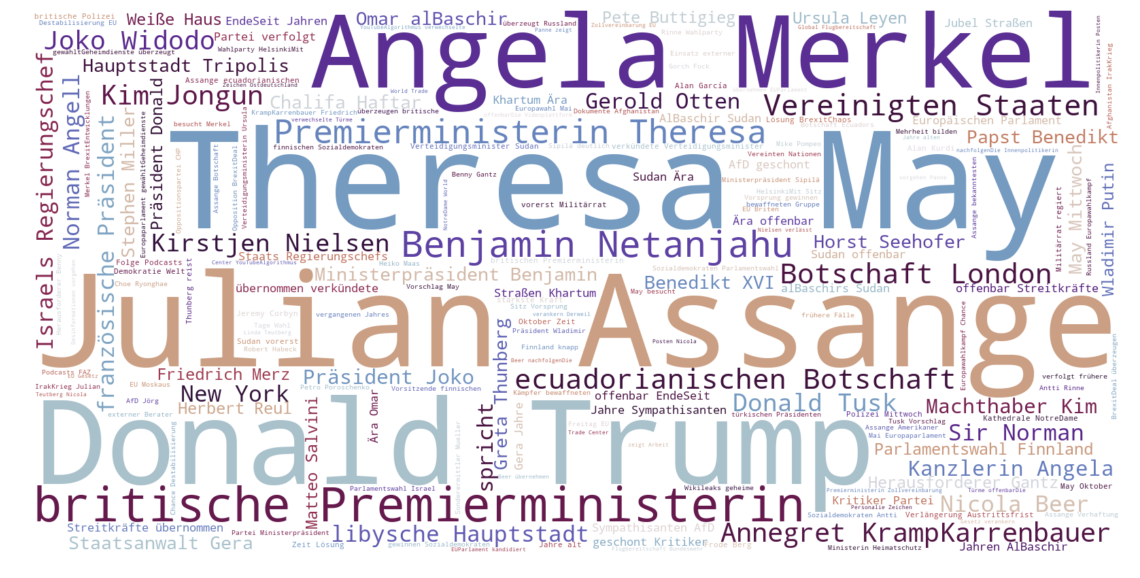

In [43]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stopwordlist, background_color='white', colormap='twilight').generate(pol_text)
plt.figure(figsize=(20,10), )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

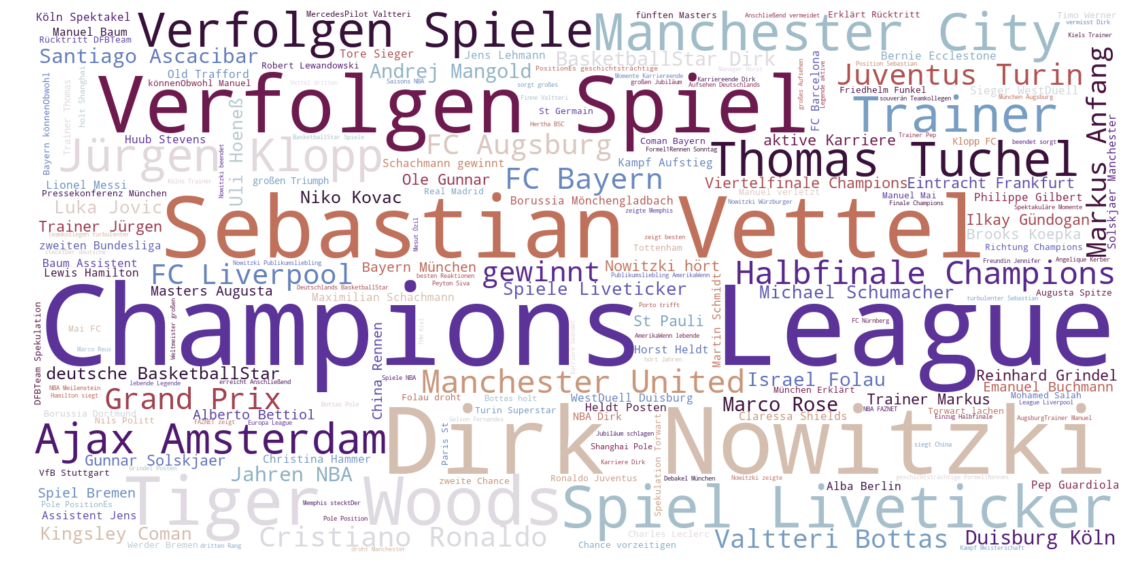

In [44]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stopwordlist, background_color='white', colormap='twilight').generate(sport_text)
plt.figure(figsize=(20,10), )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

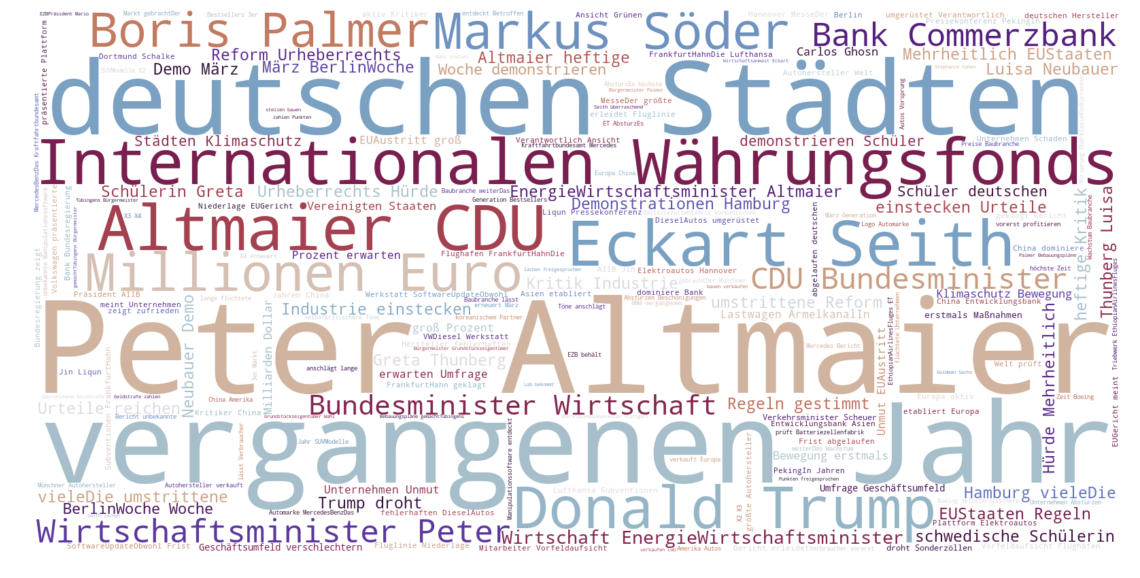

In [45]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stopwordlist, background_color='white', colormap='twilight').generate(eco_text)
plt.figure(figsize=(20,10), )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()